In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import Modules

In [ ]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
from keras.initializers import Constant

# 2. Load bộ dữ liệu NER



In [ ]:
train = "/content/drive/MyDrive/PhoNER_COVID19-main /word/train_word.conll"
dev = "/content/drive/MyDrive/PhoNER_COVID19-main /word/dev_word.conll"
test = "/content/drive/MyDrive/PhoNER_COVID19-main /word/test_word.conll"

In [ ]:
sentences_train = []
with open(train) as f:
  sentence = []
  for i, line in enumerate(f.readlines()):
    try:
      word, tag = line.split()
      sentence.append((word,tag))
    except:
      sentences_train.append(sentence)
      sentence = []


sentences_dev = []
with open(dev) as f:
  sentence = []
  for i, line in enumerate(f.readlines()):
    try:
      word, tag = line.split()
      sentence.append((word,tag))
    except:
      sentences_dev.append(sentence)
      sentence = []


sentences_test = []
with open(test) as f:
  sentence = []
  for i, line in enumerate(f.readlines()):
    try:
      word, tag = line.split()
      sentence.append((word,tag))
    except:
      sentences_test.append(sentence)
      sentence = []

## Mô tả bộ dữ liệu
Thông kê bộ dữ liệu:
- Số lượng câu trong các tập train, dev, test. 
- Số lượng từ duy nhất
- Số lượng thẻ duy nhất trong tập dữ liệu. (Tập nhãn)




In [ ]:
print(len(sentences_train))
print(len(sentences_dev))
print(len(sentences_test))

5027
2000
3001


In [ ]:
words = []
sentences_corpus=[sentences_train,sentences_dev,sentences_test]
for i in sentences_corpus:
    words += [word[0] for sent in i for word in sent]
words = list(set(words))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
print(words)
print(num_words)

['nội_thành', 'phạm_nhân', 'huyết_học', 'cưới', '715', 'Được', 'hoạt_tính', 'tiếp_đón', 'công_điện', 'Phạm_Văn_Hiệp', 'Thăng', '350', 'ăn_ngủ', 'nhiễm', 'Guam', 'Trần_Quý_Cáp', '435', 'giây', '754', '451', 'Mountain_River_Homestay_Sapa', 'Đông_Hưng_Thuận', 'Trần_Đắc_Phu', 'Bình_Định', '169', 'Tiểu', 'Hậu_Giang', 'UBND', 'Thanh_Bình', 'canteen', 'thuỳ', '21h22', 'chia_tay', 'tháo', 'Đông_Anh', 'Neelam', 'xin', 'trợ_giúp', 'mang', '533', 'kỹ_lưỡng', 'bù_trừ', 'nhưng', 'chuyến', 'Đồng_Văn', 'Bộ_trưởng', '712', 'Huyền_Trân_Công_Chúa', 'du_thuyền', '403', 'H.C.G', 'Phước', 'tương_đồng', '12/8', 'Nam_sinh', 'đi_cầu', 'nông_thôn', 'Giải_thích', 'lực', 'tiếp_thị', '24/49', 'nguồn', '935', 'giường_bệnh', '16A', 'cũ', 'stent', 'Nguồn', 'dã_chiến', 'chỉnh', 'bí_ẩn', 'dịch', 'Lào_Cai', 'tai_biến', 'P.N.S.', '438', 'Quỳnh_Lưu', 'rưng_rưng', 'tặng', '28A', 'bệnh_tình', 'khỏi', 'Mỹ', '95', '348', '682', '960', 'Hoà_Lạc', '16h30', 'khó_ở', '21/63/15', 'Hoà_Khánh_Bắc', '577', 'thể_thao', 'kg', 'y_b

In [ ]:
tags = []
for i in sentences_corpus:
    for sent in i:
        for tag in sent:
            tags.append(tag[1])
tags = list(set(tags))
num_tags = len(tags)

In [ ]:
print(tags)
print(num_tags)

['B-ORGANIZATION', 'O-ORGANIZATION', 'B-LOCATION', 'B-AGE', 'B-SYMPTOM_AND_DISEASE', 'I-JOB', 'O', 'I-SYMPTOM_AND_DISEASE', 'I-TRANSPORTATION', 'B-TRANSPORTATION', 'I-NAME', 'I-PATIENT_ID', 'B-JOB', 'I-ORGANIZATION', 'B-NAME', 'I-AGE', 'I-LOCATION', 'I-DATE', 'B-PATIENT_ID', 'B-GENDER', 'B-DATE']
21


In [ ]:
sentences_corpus

# 3. Tiền xử lý 

#### Ánh xạ giữa các câu và chỉ mục

In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
tag2idx

{'B-AGE': 0,
 'B-DATE': 13,
 'B-GENDER': 14,
 'B-JOB': 15,
 'B-LOCATION': 6,
 'B-NAME': 12,
 'B-ORGANIZATION': 16,
 'B-PATIENT_ID': 8,
 'B-SYMPTOM_AND_DISEASE': 7,
 'B-TRANSPORTATION': 11,
 'I-AGE': 19,
 'I-DATE': 1,
 'I-JOB': 17,
 'I-LOCATION': 18,
 'I-NAME': 3,
 'I-ORGANIZATION': 5,
 'I-PATIENT_ID': 9,
 'I-SYMPTOM_AND_DISEASE': 10,
 'I-TRANSPORTATION': 2,
 'O': 20,
 'O-ORGANIZATION': 4}

#### Padding  đầu vào.
Trong trục X, có thể thấy độ dài an toàn của câu là khoảng 50.

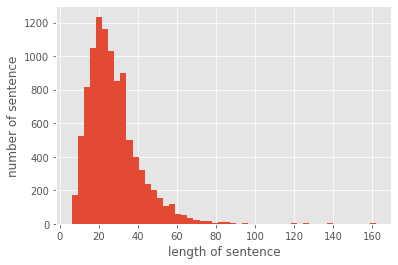

In [ ]:
plt.hist([len(s) for s in sentences_train+sentences_dev+sentences_test], bins=50)
plt.xlabel("length of sentence")
plt.ylabel('number of sentence')
plt.show()

- Sử dụng hàm pad_sequence() cho padding
- X sẽ là một đại diện bằng số cho các từ. (sử dụng word2idx)
- ‘Post’ chỉ là một giá trị của đối số đệm ở cuối câu.
- X,y là vector

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 95
X_train = [[word2idx[w[0]] for w in s] for s in sentences_train]
X_train = pad_sequences(maxlen=max_len, sequences=X_train, padding="post", value=num_words-1)
X_dev = [[word2idx[w[0]] for w in s] for s in sentences_dev]
X_dev = pad_sequences(maxlen=max_len, sequences=X_dev, padding="post", value=num_words-1)
X_test = [[word2idx[w[0]] for w in s] for s in sentences_test]
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=num_words-1)

y_train = [[tag2idx[w[1]] for w in s] for s in sentences_train]
y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=tag2idx["O"])
y_dev = [[tag2idx[w[1]] for w in s] for s in sentences_dev]
y_dev = pad_sequences(maxlen=max_len, sequences=y_dev, padding="post", value=tag2idx["O"])
y_test = [[tag2idx[w[1]] for w in s] for s in sentences_test]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])

In [ ]:
word2idx["ENDPAD"]

8102

In [ ]:
print(X_train[0])
print(y_train[0])

[5670 4436 1938 2084 1501 2297 2218 1030 7330 6272 4272 5516 7142  756
 2377 5027 5868 3232 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101]
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 16  5 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]


# 4. Hai lớp BiLSTM

### 4.1. Xây dựng mô hình

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy 

input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words + 2, output_dim=70, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.1))(model)
model = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.1))(model)

out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)

model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 95)]              0         
                                                                 
 embedding (Embedding)       (None, 95, 70)            567280    
                                                                 
 spatial_dropout1d (SpatialD  (None, 95, 70)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 95, 1024)         2387968   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 95, 1024)         6295552   
 nal)                                                            
                                                             

In [ ]:
model.compile(optimizer= "adam",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

### 4.2. Huấn luyện mô hình

In [ ]:
history = model.fit(X_train, y_train,  batch_size=128, epochs=20,  validation_split=0.1)

Epoch 1/20
36/36 [==============================] - 100s 3s/step - loss: 0.5774 - acc: 0.9148 - val_loss: 0.2648 - val_acc: 0.9450
Epoch 2/20
36/36 [==============================] - 90s 2s/step - loss: 0.2640 - acc: 0.9418 - val_loss: 0.2296 - val_acc: 0.9459
Epoch 3/20
36/36 [==============================] - 90s 3s/step - loss: 0.2228 - acc: 0.9457 - val_loss: 0.1874 - val_acc: 0.9512
Epoch 4/20
36/36 [==============================] - 90s 2s/step - loss: 0.1806 - acc: 0.9518 - val_loss: 0.1414 - val_acc: 0.9604
Epoch 5/20
36/36 [==============================] - 89s 2s/step - loss: 0.1189 - acc: 0.9652 - val_loss: 0.0994 - val_acc: 0.9729
Epoch 6/20
36/36 [==============================] - 89s 2s/step - loss: 0.0817 - acc: 0.9769 - val_loss: 0.0747 - val_acc: 0.9813
Epoch 7/20
36/36 [==============================] - 89s 2s/step - loss: 0.0622 - acc: 0.9832 - val_loss: 0.0681 - val_acc: 0.9831
Epoch 8/20
36/36 [==============================] - 89s 2s/step - loss: 0.0487 - acc: 0.9

### 4.3. Đánh giá mô hình

In [ ]:
score_test = model.evaluate(X_test, y_test, batch_size = 128, verbose = 1)

24/24 [==============================] - 14s 597ms/step - loss: 0.1041 - acc: 0.9828


In [ ]:
# i = np.random.randint(0, x_test.shape[0]) #659
print(X_test[1])
i = 2
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

[5931 3549 1842 7160  126 8059 7881 4138 7229 3229 5402 1842 5681  339
 5258 7189 6844 5258  897 7798 3200 6962 1842 7818 6996 1842 4024 5419
 6640 2883   77 7222 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101]
Word           True 	 Pred

------------------------------
Theo           O	O
đó             O	O
,              O	O
Sở             B-ORGANIZATION	B-ORGANIZATION
Y_tế           I-ORGANIZATION	I-ORGANIZATION
Bình_Thuận     I-ORGANIZATION	I-ORGANIZATION
cho            O	O
biết           O	O
sau            O	O
khi            O	O
xác_định       O	O
bệnh_nhân      O	O
số             O	O
34             B-PATIENT_ID	B-PATIENT_ID
(              O	O
nữ_giới        B-GENDER	O
51             B-AGE	B-AGE
tuổi           O	O
,

In [ ]:
y_pred = model.predict(X_test)

y_pred_argmax = np.argmax(y_pred, axis=2)
y_pred_argmax_flattened = y_pred_argmax.ravel()
y_test_flattened = y_test.ravel()


In [ ]:
#Đánh giá mô hình theo độ đo F1-score và Accuracy (micro và macro)
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

print('F1_score (macro): ', f1_score(y_test_flattened, y_pred_argmax_flattened, average='macro')*100)
print('F1_score (micro): ', f1_score(y_test_flattened, y_pred_argmax_flattened, average='micro')*100)
print('Accuracy: ', accuracy_score(y_test_flattened, y_pred_argmax_flattened)*100)


F1_score (macro):  63.629833878478145
F1_score (micro):  98.27881934092146
Accuracy:  98.27881934092146


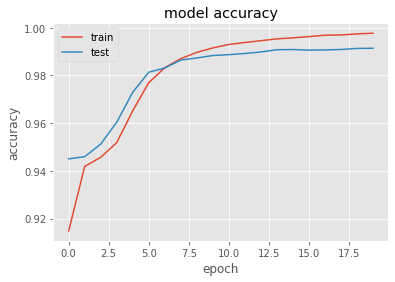

In [ ]:
#đồ thị học của mô hình với thông số accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

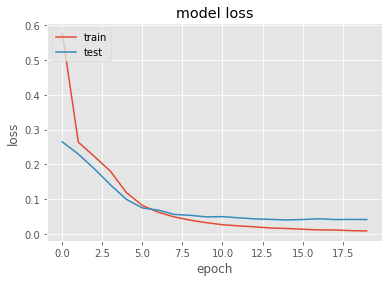

In [ ]:
#đồ thị học của mô hình với thông số loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Xuất ra kết quả của F1-score và Accuracy cho từng nhãn thực thể.

report_2t = classification_report(y_test_flattened, y_pred_argmax_flattened, 
                               labels = list(tag2idx.values()),
                               target_names=list(tag2idx.keys()))
print(report_2t)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

                       precision    recall  f1-score   support

               I-NAME       0.00      0.00      0.00        13
         I-PATIENT_ID       0.00      0.00      0.00        27
             B-GENDER       0.87      0.85      0.86       452
               B-NAME       0.74      0.46      0.56       318
               B-DATE       0.96      0.95      0.96      1649
                    O       0.99      1.00      0.99    263037
       B-ORGANIZATION       0.82      0.77      0.79       771
     I-TRANSPORTATION       0.67      0.35      0.46        69
           I-LOCATION       0.92      0.79      0.85      4905
       O-ORGANIZATION       0.00      0.00      0.00         0
           B-LOCATION       0.92      0.84      0.88      4432
I-SYMPTOM_AND_DISEASE       0.84      0.69      0.76      1486
               I-DATE       0.97      0.98      0.98      1740
         B-PATIENT_ID       0.88      0.84      0.86      1988
     B-TRANSPORTATION       0.91      0.51      0.65  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 5. Mô hình LSTM hai chiều (bi-LSTM)

### 5.1. Xây dựng mô hình

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy 
from keras.initializers import Constant


input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words,
                    output_dim=embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_len,
                    trainable=True)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 95)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 95, 50)            405100    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 95, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 95, 1024)         2306048   
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 95, 21)           21525     
 tributed)                                                       
                                                           

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

### 5.2.  Huấn luyện mô hình

In [ ]:
import time
start_time = time.time()

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_dev,y_dev),
    validation_split= 0.1,
    batch_size= 128, 
    epochs=20,
    verbose=1
)
print("[{}] Completed!".format(time.time() - start_time))

Epoch 1/20
36/36 [==============================] - 47s 1s/step - loss: 0.3994 - acc: 0.9123 - val_loss: 0.2372 - val_acc: 0.9450
Epoch 2/20
36/36 [==============================] - 41s 1s/step - loss: 0.2170 - acc: 0.9443 - val_loss: 0.1723 - val_acc: 0.9531
Epoch 3/20
36/36 [==============================] - 41s 1s/step - loss: 0.1528 - acc: 0.9596 - val_loss: 0.1191 - val_acc: 0.9685
Epoch 4/20
36/36 [==============================] - 40s 1s/step - loss: 0.1114 - acc: 0.9703 - val_loss: 0.0911 - val_acc: 0.9745
Epoch 5/20
36/36 [==============================] - 40s 1s/step - loss: 0.0874 - acc: 0.9761 - val_loss: 0.0726 - val_acc: 0.9793
Epoch 6/20
36/36 [==============================] - 41s 1s/step - loss: 0.0719 - acc: 0.9801 - val_loss: 0.0611 - val_acc: 0.9834
Epoch 7/20
36/36 [==============================] - 40s 1s/step - loss: 0.0622 - acc: 0.9825 - val_loss: 0.0551 - val_acc: 0.9855
Epoch 8/20
36/36 [==============================] - 40s 1s/step - loss: 0.0534 - acc: 0.98

### 5.3. Đánh giá mô hình NER

In [ ]:
score_test = model.evaluate(X_test, y_test, batch_size = 128, verbose = 1)

24/24 [==============================] - 5s 200ms/step - loss: 0.0668 - acc: 0.9835


In [ ]:
# i = np.random.randint(0, x_test.shape[0]) #659
print(X_test[1])
i = 2
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

[5931 3549 1842 7160  126 8059 7881 4138 7229 3229 5402 1842 5681  339
 5258 7189 6844 5258  897 7798 3200 6962 1842 7818 6996 1842 4024 5419
 6640 2883   77 7222 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101]
Word           True 	 Pred

------------------------------
Theo           O	O
đó             O	O
,              O	O
Sở             B-ORGANIZATION	B-ORGANIZATION
Y_tế           I-ORGANIZATION	I-ORGANIZATION
Bình_Thuận     I-ORGANIZATION	I-ORGANIZATION
cho            O	O
biết           O	O
sau            O	O
khi            O	O
xác_định       O	O
bệnh_nhân      O	O
số             O	O
34             B-PATIENT_ID	B-PATIENT_ID
(              O	O
nữ_giới        B-GENDER	O
51             B-AGE	B-AGE
tuổi           O	O
,

In [ ]:
y_pred = model.predict(X_test)

y_pred_argmax = np.argmax(y_pred, axis=2)
y_pred_argmax_flattened = y_pred_argmax.ravel()
y_test_flattened = y_test.ravel()


In [ ]:
#Đánh giá mô hình theo độ đo F1-score và Accuracy (micro và macro)
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

print('F1_score (macro): ', f1_score(y_test_flattened, y_pred_argmax_flattened, average='macro')*100)
print('F1_score (micro): ', f1_score(y_test_flattened, y_pred_argmax_flattened, average='micro')*100)
print('Accuracy: ', accuracy_score(y_test_flattened, y_pred_argmax_flattened)*100)


F1_score (macro):  66.68974766113492
F1_score (micro):  98.3468668338624
Accuracy:  98.3468668338624


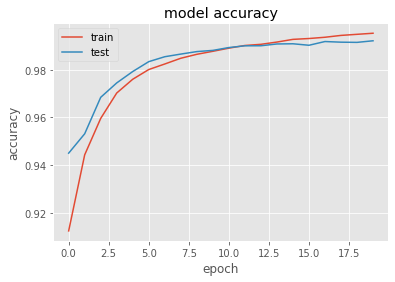

In [ ]:
#đồ thị học của mô hình với thông số accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

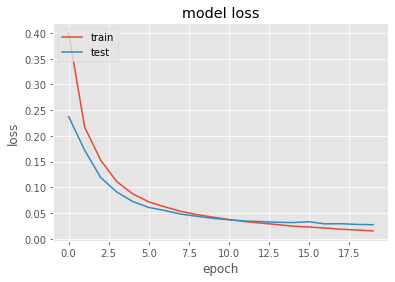

In [ ]:
#đồ thị học của mô hình với thông số loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Xuất ra kết quả của F1-score và Accuracy cho từng nhãn thực thể.
report_2t = classification_report(y_test_flattened, y_pred_argmax_flattened, 
                               labels = list(tag2idx.values()),
                               target_names=list(tag2idx.keys()))
print(report_2t)

In [ ]:
# Lưu lại mô hình và bộ trọng số đã train
model.save('BiLSTM.h5')

# 6. Mô hình SimpleRNN

### 6.1. Xây dựng mô hình

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, SimpleRNN
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=70, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = SimpleRNN(units=100, return_sequences=True, recurrent_dropout=0.1)(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 95)]              0         
                                                                 
 embedding (Embedding)       (None, 95, 70)            567140    
                                                                 
 spatial_dropout1d (SpatialD  (None, 95, 70)           0         
 ropout1D)                                                       
                                                                 
 simple_rnn (SimpleRNN)      (None, 95, 100)           17100     
                                                                 
 time_distributed (TimeDistr  (None, 95, 21)           2121      
 ibuted)                                                         
                                                                 
Total params: 586,361
Trainable params: 586,361
Non-trainable

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

### 6.2. Huấn luyện mô hình

In [ ]:
history = model.fit(X_train, y_train,  batch_size=128, epochs=20,  validation_split=0.1)

Epoch 1/20
36/36 [==============================] - 9s 162ms/step - loss: 0.7635 - acc: 0.8874 - val_loss: 0.3967 - val_acc: 0.9450
Epoch 2/20
36/36 [==============================] - 6s 155ms/step - loss: 0.3965 - acc: 0.9416 - val_loss: 0.3623 - val_acc: 0.9450
Epoch 3/20
36/36 [==============================] - 5s 151ms/step - loss: 0.3706 - acc: 0.9414 - val_loss: 0.3325 - val_acc: 0.9451
Epoch 4/20
36/36 [==============================] - 6s 154ms/step - loss: 0.3239 - acc: 0.9407 - val_loss: 0.2470 - val_acc: 0.9468
Epoch 5/20
36/36 [==============================] - 6s 154ms/step - loss: 0.2316 - acc: 0.9464 - val_loss: 0.1857 - val_acc: 0.9546
Epoch 6/20
36/36 [==============================] - 6s 155ms/step - loss: 0.1766 - acc: 0.9556 - val_loss: 0.1458 - val_acc: 0.9622
Epoch 7/20
36/36 [==============================] - 6s 153ms/step - loss: 0.1390 - acc: 0.9642 - val_loss: 0.1200 - val_acc: 0.9679
Epoch 8/20
36/36 [==============================] - 6s 155ms/step - loss: 0.

### 6.3. Đánh giá mô hình

In [ ]:
score_test = model.evaluate(X_test, y_test, batch_size = 128, verbose = 1)

24/24 [==============================] - 0s 14ms/step - loss: 0.0745 - acc: 0.9817


In [ ]:
# i = np.random.randint(0, x_test.shape[0]) #659
print(X_test[1])
i = 2
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

[6485 3159 4436 1898    1 5241 1290 3751 3188 4527 5001 4436 2467 5734
 6225 7828  682 6225 3198 4393 6200 4112 4436  118 4851 4436 3690 6993
 2898 2994 1320 3232 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101]
Word           True 	 Pred

------------------------------
Theo           O	O
đó             O	O
,              O	O
Sở             B-ORGANIZATION	B-ORGANIZATION
Y_tế           I-ORGANIZATION	I-ORGANIZATION
Bình_Thuận     I-ORGANIZATION	I-ORGANIZATION
cho            O	O
biết           O	O
sau            O	O
khi            O	O
xác_định       O	O
bệnh_nhân      O	O
số             O	O
34             B-PATIENT_ID	B-PATIENT_ID
(              O	O
nữ_giới        B-GENDER	O
51             B-AGE	O
tuổi           O	O
,    

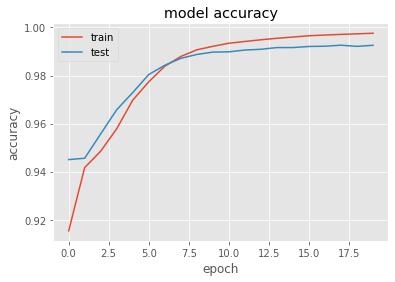

In [ ]:
#đồ thị học của mô hình với thông số accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

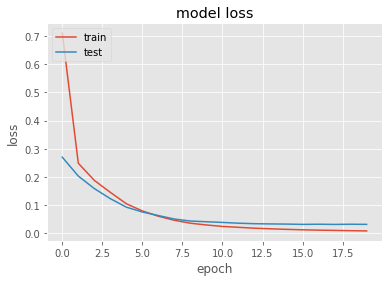

In [ ]:
#đồ thị học của mô hình với thông số loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

y_pred_argmax = np.argmax(y_pred, axis=2)
y_pred_argmax_flattened = y_pred_argmax.ravel()
y_test_flattened = y_test.ravel()

In [ ]:
#Đánh giá mô hình theo độ đo F1-score và Accuracy (micro và macro)
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

print('F1_score (macro): ', f1_score(y_test_flattened, y_pred_argmax_flattened, average='macro')*100)
print('F1_score (micro): ', f1_score(y_test_flattened, y_pred_argmax_flattened, average='micro')*100)
print('Accuracy: ', accuracy_score(y_test_flattened, y_pred_argmax_flattened)*100)

F1_score (macro):  61.10847296721285
F1_score (micro):  98.17183745768953
Accuracy:  98.17183745768953


In [ ]:
# Xuất ra kết quả của F1-score và Accuracy cho từng nhãn thực thể.
report_2t = classification_report(y_test_flattened, y_pred_argmax_flattened, 
                               labels = list(tag2idx.values()),
                               target_names=list(tag2idx.keys()))
print(report_2t)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                B-AGE       0.91      0.76      0.83       573
               I-DATE       0.93      0.97      0.95      1740
     I-TRANSPORTATION       0.95      0.28      0.43        69
               I-NAME       0.00      0.00      0.00        13
       O-ORGANIZATION       0.00      0.00      0.00         0
       I-ORGANIZATION       0.89      0.76      0.82      2014
           B-LOCATION       0.88      0.86      0.87      4432
B-SYMPTOM_AND_DISEASE       0.91      0.79      0.84      1136
         B-PATIENT_ID       0.89      0.79      0.84      1988
         I-PATIENT_ID       0.00      0.00      0.00        27
I-SYMPTOM_AND_DISEASE       0.91      0.71      0.80      1486
     B-TRANSPORTATION       0.93      0.56      0.70       193
               B-NAME       0.97      0.38      0.55       318
               B-DATE       0.95      0.94      0.95      1649
             B-GENDER       0.92      0.83      0.87  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

# 7. Mô hình GRU hai chiều (bi-GRU)

### 7.1. Xây dựng mô hình

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, SimpleRNN, GRU
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=70, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(GRU(units=512, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 95)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 95, 70)            567140    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 95, 70)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional (Bidirectiona  (None, 95, 1024)         1794048   
 l)                                                              
                                                                 
 time_distributed_1 (TimeDis  (None, 95, 21)           21525     
 tributed)                                                       
                                                           

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

### 7.2. Huấn luyện mô hình

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_split=0.1)

Epoch 1/20
36/36 [==============================] - 36s 869ms/step - loss: 0.7098 - acc: 0.9153 - val_loss: 0.2701 - val_acc: 0.9450
Epoch 2/20
36/36 [==============================] - 30s 845ms/step - loss: 0.2488 - acc: 0.9417 - val_loss: 0.2033 - val_acc: 0.9456
Epoch 3/20
36/36 [==============================] - 31s 863ms/step - loss: 0.1880 - acc: 0.9485 - val_loss: 0.1590 - val_acc: 0.9557
Epoch 4/20
36/36 [==============================] - 31s 872ms/step - loss: 0.1455 - acc: 0.9579 - val_loss: 0.1231 - val_acc: 0.9658
Epoch 5/20
36/36 [==============================] - 31s 861ms/step - loss: 0.1051 - acc: 0.9698 - val_loss: 0.0930 - val_acc: 0.9729
Epoch 6/20
36/36 [==============================] - 31s 867ms/step - loss: 0.0796 - acc: 0.9774 - val_loss: 0.0759 - val_acc: 0.9804
Epoch 7/20
36/36 [==============================] - 30s 840ms/step - loss: 0.0608 - acc: 0.9839 - val_loss: 0.0632 - val_acc: 0.9843
Epoch 8/20
36/36 [==============================] - 30s 837ms/step - 

### 7.3. Đánh giá mô hình

In [ ]:
score_test = model.evaluate(X_test, y_test, batch_size = 128, verbose = 1)

24/24 [==============================] - 3s 122ms/step - loss: 0.0834 - acc: 0.9838


In [ ]:
# i = np.random.randint(0, x_test.shape[0]) #659
print(X_test[1])
i = 2
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

[6485 3159 4436 1898    1 5241 1290 3751 3188 4527 5001 4436 2467 5734
 6225 7828  682 6225 3198 4393 6200 4112 4436  118 4851 4436 3690 6993
 2898 2994 1320 3232 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101]
Word           True 	 Pred

------------------------------
Theo           O	O
đó             O	O
,              O	O
Sở             B-ORGANIZATION	B-ORGANIZATION
Y_tế           I-ORGANIZATION	I-ORGANIZATION
Bình_Thuận     I-ORGANIZATION	I-ORGANIZATION
cho            O	O
biết           O	O
sau            O	O
khi            O	O
xác_định       O	O
bệnh_nhân      O	O
số             O	O
34             B-PATIENT_ID	B-PATIENT_ID
(              O	O
nữ_giới        B-GENDER	O
51             B-AGE	O
tuổi           O	O
,    

In [ ]:
y_pred = model.predict(X_test)

y_pred_argmax = np.argmax(y_pred, axis=2)
y_pred_argmax_flattened = y_pred_argmax.ravel()
y_test_flattened = y_test.ravel()


In [ ]:
#Đánh giá mô hình theo độ đo F1-score và Accuracy (micro và macro)
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

print('F1_score (macro): ', f1_score(y_test_flattened, y_pred_argmax_flattened, average='macro')*100)
print('F1_score (micro): ', f1_score(y_test_flattened, y_pred_argmax_flattened, average='micro')*100)
print('Accuracy: ', accuracy_score(y_test_flattened, y_pred_argmax_flattened)*100)


F1_score (macro):  65.72617160988476
F1_score (micro):  98.38334590224311
Accuracy:  98.38334590224311


In [ ]:
# Xuất ra kết quả của F1-score và Accuracy cho từng nhãn thực thể.
report_2t = classification_report(y_test_flattened, y_pred_argmax_flattened, 
                               labels = list(tag2idx.values()),
                               target_names=list(tag2idx.keys()))
print(report_2t)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

                       precision    recall  f1-score   support

                B-AGE       0.90      0.93      0.91       573
               I-DATE       0.97      0.98      0.98      1740
     I-TRANSPORTATION       0.55      0.32      0.40        69
               I-NAME       1.00      0.08      0.14        13
       O-ORGANIZATION       0.00      0.00      0.00         0
       I-ORGANIZATION       0.90      0.77      0.83      2014
           B-LOCATION       0.93      0.87      0.90      4432
B-SYMPTOM_AND_DISEASE       0.91      0.78      0.84      1136
         B-PATIENT_ID       0.97      0.79      0.87      1988
         I-PATIENT_ID       0.00      0.00      0.00        27
I-SYMPTOM_AND_DISEASE       0.91      0.67      0.77      1486
     B-TRANSPORTATION       0.85      0.57      0.68       193
               B-NAME       0.84      0.49      0.62       318
               B-DATE       0.98      0.95      0.96      1649
             B-GENDER       0.95      0.90      0.93  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Lưu lại mô hình và bộ trọng số đã train
model.save('BiGRU.h5')